In [121]:
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_bodies.csv
!wget https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/competition_test_stances.csv

--2022-07-30 09:55:33--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_stances.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4255300 (4.1M) [text/plain]
Saving to: ‘train_stances.csv.1’

train_stances.csv.1 100%[===================>]   4.06M  --.-KB/s    in 0.07s   

2022-07-30 09:55:34 (57.4 MB/s) - ‘train_stances.csv.1’ saved [4255300/4255300]

--2022-07-30 09:55:34--  https://raw.githubusercontent.com/FakeNewsChallenge/fnc-1/master/train_bodies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3

In [2]:
#Install neattext for datacleaning
!pip install neattext



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 5.2 MB/s 


In [3]:
#Dependencies
import pandas as pd
import os
from nltk import word_tokenize
import numpy as np
from pandas.core.frame import DataFrame
import torch
from collections import namedtuple
from torch.utils.data import Dataset, DataLoader
import neattext.functions as nfx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print(torch.cuda.is_available())

True


In [123]:
train_stances_path = os.path.join("train_stances.csv")
train_bodies_path = os.path.join("train_bodies.csv")
train_stances = pd.read_csv(train_stances_path)
train_bodies = pd.read_csv(train_bodies_path)
train_stances['Stance']

test_stances_path = os.path.join("competition_test_stances.csv")
test_bodies_path = os.path.join("competition_test_bodies.csv")
test_stances = pd.read_csv(test_stances_path)
test_bodies = pd.read_csv(test_bodies_path)
test_stances['Stance']

0        unrelated
1        unrelated
2        unrelated
3        unrelated
4        unrelated
           ...    
25408        agree
25409      discuss
25410     disagree
25411     disagree
25412        agree
Name: Stance, Length: 25413, dtype: object

In [127]:
def plot_stance_value_counts(data, column='Stance'):
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(x=column, data=data)
    # ax.bar_label(ax.containers[0])
    plt.title("Value counts for Stances")
    plt.show()

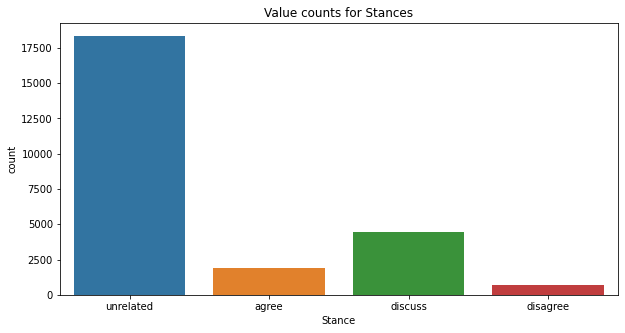

In [128]:
plot_stance_value_counts(test_stances)

In [ ]:
# test_bodies.head()

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [ ]:
# selected_features = ['Headline','articleBody','Stance']
# train_data = train_stances.join(train_bodies.set_index("Body ID"), on="Body ID")
# test_data = test_stances.join(test_bodies.set_index("Body ID"), on="Body ID")
# train = train_data.loc[:, train_data.columns.isin(selected_features)]


In [ ]:
# train.head()

,Headline,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [129]:
#Dataset
STOP_TOKEN = '</s>'
START_TOKEN = '<s>'
UNK_TOKEN = '<unk>'
PAD_TOKEN = '<pad>'

class FakeDataset(Dataset):
    def __init__(self, data, word2idx, tokenizer,headline_max_length,body_max_length):
        self.articles = data
        self.w2i = word2idx
        self.tokenizer = tokenizer
        self.max_len_h = headline_max_length
        self.max_len_b = body_max_length

    def __len__(self):
        return len(self.articles)
    
    def __getitem__(self, idx):
        headline_ids = []
        body_ids = []
        stances_ids = []
        stances_list = ['agree','disagree','discuss','unrelated']
          

        headline = self.articles[idx].Headline
        body = self.articles[idx].articleBody
        stance = self.articles[idx].Stance

        headline_words = self.tokenizer(headline)
        body_words = self.tokenizer(body)
        for i in headline_words:
            try:
                idx = self.w2i[i]
            except KeyError:
                idx = self.w2i[UNK_TOKEN]
            headline_ids.append(idx)
        for j in body_words:
            try:
                idx = self.w2i[j]
            except KeyError:
                idx = self.w2i[UNK_TOKEN]
            body_ids.append(idx)

        # stance_list_int = [stances_list.index(stance_i) if stance_i == stance else 0 for stance_i in stances_list]
        # stances_ids.append(stance_list_int)

        stance_list_int = [1 if stance_i == stance else 0 for stance_i in stances_list]
        stances_ids.append(stance_list_int)
  
        headline_length = len(headline_ids)
        body_length = len(body_ids)
        if headline_length < self.max_len_h:
            headline_ids = headline_ids + [self.w2i[STOP_TOKEN]] + [self.w2i[PAD_TOKEN]] * (self.max_len_h - headline_length - 1)
            assert len(headline_ids) == self.max_len_h
            headline_length += 1
        else:
            headline_ids = headline_ids[:self.max_len_h-1] + [self.w2i[STOP_TOKEN]]
            headline_length = self.max_len_h
            
        if body_length < self.max_len_b-1:
            body_ids = [self.w2i[START_TOKEN]] + body_ids + [self.w2i[STOP_TOKEN]] +\
            [self.w2i[PAD_TOKEN]] * (self.max_len_b - body_length - 2)
            assert len(body_ids) == self.max_len_b
            body_length += 2
        else:
            body_ids = [self.w2i[START_TOKEN]] + body_ids[:self.max_len_b-2] + [self.w2i[STOP_TOKEN]]
            body_length = self.max_len_b
            
        headline_mask = np.zeros(self.max_len_h)
        body_mask = np.zeros(self.max_len_b)
        headline_mask[:headline_length] = 1
        body_mask[:body_length] = 1

        return torch.LongTensor(headline_ids), torch.LongTensor(body_ids), torch.LongTensor([headline_length]), \
        torch.LongTensor([body_length]),  torch.BoolTensor(headline_mask), torch.BoolTensor(body_mask), torch.LongTensor(stances_ids)

In [130]:

#Utils
selected_features = ['Headline','articleBody','Stance']
Article = namedtuple('Article', selected_features)

def data_cleaning(df,columns):
  for column in columns:

    df[column] = df[column].apply(nfx.remove_stopwords)
    df[column] = df[column].apply(nfx.remove_userhandles)
    df[column] = df[column].apply(nfx.remove_punctuations)
    df[column] = df[column].apply(nfx.remove_emojis)
    df[column] = df[column].apply(nfx.remove_emails)
    df[column] = df[column].apply(nfx.remove_urls)
  return df

def build_vocabulary(body,headline):
  body_list = body.split()
  headline_list = headline.split()
  combined_list = body_list+headline_list
  return set(combined_list)

def read_corpus(data_path_stance,data_path_body):
    '''
    param: 
    data_path_stance: str --- path to the data file containing stance and headline
    data_path_body: str --- path to the data file containing body

    return: 
    headline: list[str] --- contains the text in headline; 
    articleBody: list[str] --- contains the text in articleBody; 
    vocab: set(str) --- contains all the words appearing in the data file;
    stance: list[str] --- contains list of stance;

    '''
   
    stancesDf = pd.read_csv(data_path_stance)
    bodiesDf = pd.read_csv(data_path_body)    
    headline, articleBody, stance = [], [], []
    vocab = set()

    
    dataframe = stancesDf.join(bodiesDf.set_index("Body ID"), on="Body ID")
   
    dataframe = dataframe.loc[:, dataframe.columns.isin(selected_features)]
    dataframe = data_cleaning(dataframe,selected_features)
  
    headline = [x for x in dataframe['Headline']]
    articleBody = [x for x in dataframe['articleBody']]
    stance = [x for x in dataframe['Stance']]
    for x,y in zip(dataframe['Headline'],dataframe['articleBody']):
      temp_set =  build_vocabulary(x,y)
      vocab = vocab | temp_set

  






    return headline, articleBody, stance, vocab

def data_matching(headlines, articleBodies,stances):
    data = []
    for h,b,s in zip(headlines, articleBodies,stances):
        data.append(Article(Headline=h, articleBody=b,Stance=s))
    return data

def build_w2i(vocab):

    w2i = {}
    for i, w in enumerate(vocab):
        w2i[w] = i
    w2i[START_TOKEN] = len(w2i)
    w2i[STOP_TOKEN] = len(w2i)
    w2i[UNK_TOKEN] = len(w2i)
    w2i[PAD_TOKEN] = len(w2i)

    return w2i 

def build_i2w(w2i):
    i2w = {}
    for k,v in w2i.items():
        i2w[v] = k    
    return i2w

In [131]:
headline, articleBody, stance, vocab = read_corpus(r'train_bodies.csv',r'train_stances.csv')
test_headline, test_articleBody, test_stance, test_vocab = read_corpus(r'competition_test_bodies.csv',r'competition_test_stances.csv')
# test_src, test_tgt, _, _ = read_corpus(r'data/part2/test')

train_data = data_matching(headline,articleBody,stance)
# test_sent_pairs = lang_pairs(test_src,test_tgt)
test_data = data_matching(test_headline, test_articleBody, test_stance)

w2i = build_w2i(vocab)
i2w = build_i2w(w2i)

In [11]:
print(len(vocab), len(headline), len(articleBody))
print(len(w2i), len(i2w))

37044 49972 49972
37048 37048


In [132]:
tokenizer = lambda x: x.split()
max_length_headline = 40
max_length_body = 110
batchsize = 32
train_dataset = FakeDataset(train_data,w2i,tokenizer,max_length_headline,max_length_body)
test_dataset = FakeDataset(test_data,w2i,tokenizer,max_length_headline,max_length_body)



train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batchsize,shuffle=False)

device = 'cuda:0' if torch.cuda.is_available else 'cpu'

In [133]:
print(torch.cuda.is_available())

True


In [134]:
class FakeModel(nn.Module):
  def __init__(self,embedding_size,vocab_size):
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_size = embedding_size


    self.embed = nn.Embedding(self.vocab_size,self.embed_size)
    self.dropout = nn.Dropout(0.2)
    self.conv1D = nn.Conv1d(150,64,5)
    self.pooling = nn.MaxPool1d(4,4)
    self.conv1D_2 = nn.Conv1d(64,4,5)
    self.pooling_2 = nn.MaxPool1d(4,4)
    self.lstm = nn.LSTM(batch_first = True,input_size=11,hidden_size = 100,num_layers = 1, bidirectional = True)
    self.fc = nn.Linear(200,32)
    self.fc2 = nn.Linear(32,1)


  def forward(self,x,headline_length,body_length):
    embed = self.embed(x)
    x = self.conv1D(embed)
    
    x = F.relu(x)
    x = self.pooling(x)
    x = self.dropout(x)

    x = self.conv1D_2(x)
    x = F.relu(x)
    x = self.pooling_2(x)
    x = self.dropout(x)

    # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu()) 
    output, (hidden,cell)  = self.lstm(x)


    x = self.fc(output)
    x = self.fc2(x)
    return F.log_softmax(x,dim=1)




   


In [135]:
embedding_size = 200
vocab_size = len(w2i)
criterion = nn.NLLLoss(reduction='mean')
model = FakeModel(embedding_size,vocab_size)
model = model.to(device)
optimizer = optim.SGD(model.parameters(),lr = 1e-5)
# optimizer = optim.Adam(model.parameters(),lr = 3e-3)
epoch_num = 100

In [136]:
def accuracy(pred,target):
  idx_pred = torch.argmax(pred, dim=1).squeeze(dim=1)
  idx_target = torch.argmax(target,dim=1)
  correct = idx_pred==idx_target
  score = correct.sum()/len(correct)
  
  return score


In [138]:
def train(model, data_loader, optimizer, criterion,epoch_num):
    epoch_loss_list=[]
    acc_total_list=[]
    for epoch in range(epoch_num):
      
      epoch_loss = 0
      acc_total = 0
      model.train()
      for batch_data in data_loader:
          optimizer.zero_grad()
          batch_data = tuple(t.to(device) for t in batch_data[:])
          headline_ids, body_ids, headline_length, body_length,  headline_mask, body_mask, stance_ids = batch_data
          
          input = torch.cat((headline_ids,body_ids),dim=1)
          
          predictions = model(input,headline_length,body_length)
          # predictions = predictions.type(torch.FloatTensor).cuda().squeeze(2)
          # loss = criterion(predictions, stance_ids.squeeze(1))
          stance_ids = stance_ids.squeeze(1)
          stance_idx = torch.argmax(stance_ids,dim=1)
          loss = criterion(predictions.squeeze(2), stance_idx)
          
          
          acc = accuracy(predictions,stance_ids)
          # print(acc)
          # print(acc/stance_ids.size()[0])
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
          acc_total+=acc.item()
      epoch_loss_list.append(epoch_loss)
      acc_total_list.append(acc_total)
      
      if (epoch%10==0):
        print('Epoch: {}, loss is {}'.format(epoch+1,epoch_loss))
        print('Epoch: {}, acc is {}'.format(epoch+1,acc_total/len(data_loader)))
      
    return epoch_loss_list, acc_total_list

In [139]:
loss_list, acc_list = train(model,train_loader,optimizer,criterion,epoch_num)

Epoch: 1, loss is 2172.6313573122025
Epoch: 1, acc is 0.08785211267701032
Epoch: 11, loss is 2169.061653614044
Epoch: 11, acc is 0.12799295774695588
Epoch: 21, loss is 2163.711428642273
Epoch: 21, acc is 0.29508242638788823
Epoch: 31, loss is 2153.837511897087
Epoch: 31, acc is 0.6328945262560314
Epoch: 41, loss is 2133.5735663175583
Epoch: 41, acc is 0.7269246158847125
Epoch: 51, loss is 2094.0321576595306
Epoch: 51, acc is 0.7311499680126522
Epoch: 61, loss is 2025.7410929203033
Epoch: 61, acc is 0.731282010235646
Epoch: 71, loss is 1922.060644865036
Epoch: 71, acc is 0.7313140204865557
Epoch: 81, loss is 1782.3662123680115
Epoch: 81, acc is 0.7313140204865557
Epoch: 91, loss is 1621.6284714341164
Epoch: 91, acc is 0.7312900128269928


In [142]:
def evaluate(model, data_loader, optimizer, criterion):

    epoch_loss = 0
    acc_total = 0
    model.eval()
    for batch_data in data_loader:
        optimizer.zero_grad()
        batch_data = tuple(t.to(device) for t in batch_data[:])
        headline_ids, body_ids, headline_length, body_length,  headline_mask, body_mask, stance_ids = batch_data
        
        input = torch.cat((headline_ids,body_ids),dim=1)
        
        predictions = model(input,headline_length,body_length)
        # predictions = predictions.type(torch.FloatTensor).cuda().squeeze(2)
        # loss = criterion(predictions, stance_ids.squeeze(1))
        stance_ids = stance_ids.squeeze(1)
        stance_idx = torch.argmax(stance_ids,dim=1)
        loss = criterion(predictions.squeeze(2), stance_idx)
        
        
        acc = accuracy(predictions,stance_ids)
        # print(acc)
        # print(acc/stance_ids.size()[0])
        epoch_loss += loss.item()
        acc_total+=acc.item()
    
    
    print('Test loss is {}'.format(epoch_loss))
    print('Test acc is {}'.format(acc_total/len(data_loader)))
    
    return epoch_loss, acc_total

In [143]:
test_loss, test_acc = evaluate(model,test_loader,optimizer,criterion)

Test loss is 752.4014182090759
Test acc is 0.7212657232704403


In [144]:
torch.save(model.state_dict(), "fake_model.pt")

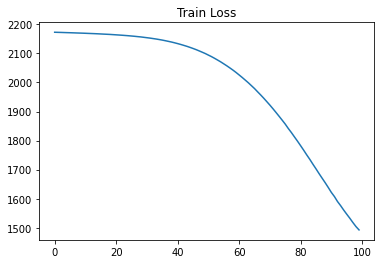

In [145]:
epoch_array = np.arange(epoch_num)
loss_array=np.array(loss_list)

plt.plot(epoch_array, loss_array, label='loss')

plt.title("Train Loss")
plt.xlabel = 'Number of epoch'
plt.ylable = 'Loss'
plt.show()

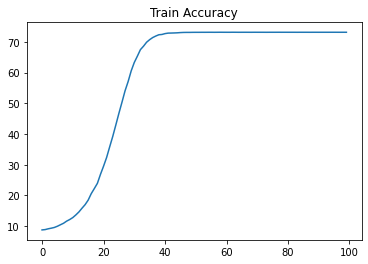

In [146]:
epoch_array = np.arange(epoch_num)

acc_array = np.array(acc_list)/len(train_loader)*100
plt.plot(epoch_array, acc_array, label='accuracy')
plt.title("Train Accuracy")
plt.xlabel = 'Number of epoch'
plt.ylable = 'Accuracy'
plt.show()